In [18]:
# combining everything we have 
import cv2;
import numpy as np;
from matplotlib import pyplot as plt;
from pywt import dwt2, idwt2;
import pywt;

def find_neighbors(index, dim):
    all_neighbors = []
    x, y = index
    width, height = dim
    
    all_neighbors.append((x, y - 1))
    all_neighbors.append((x, y + 1))
    all_neighbors.append((x - 1, y))
    all_neighbors.append((x + 1, y))
    all_neighbors.append((x - 1, y - 1))
    all_neighbors.append((x + 1, y - 1))
    all_neighbors.append((x - 1, y + 1))
    all_neighbors.append((x + 1, y + 1))

    neighbors = [index]
    #     save the location that the pixel is on for comparison
    for i in all_neighbors:
        if (i[0] >= width) or (i[1] >= height):
            continue
        elif (i[0] >= 0) and (i[1] >= 0):
            neighbors.append(i)
    return neighbors

# generates the prewitt kernels which will give us the approximate second derivative of gaussian 
def kernelGen(dim, isX):
    if(isX):
        kernelx = np.ones((1,dim), dtype = int) * -1
        zeros = np.zeros((1,dim), dtype = int)
        ones = np.ones((1,dim), dtype = int)
        for num in range(0,dim-2):
            kernelx = np.concatenate((kernelx, zeros), axis = -1)
        kernelx = np.concatenate((kernelx, ones), axis = -1)
        kernelx = np.resize(kernelx, (dim,dim))
        return kernelx
    else:
        kernely =  np.ones((dim,1), dtype = int) * -1
        zeros = np.zeros((dim,1), dtype = int)
        ones = np.ones((dim,1), dtype = int)
        for num in range(0,dim-2):
            kernely = np.concatenate((kernely, zeros), axis = -1)
        kernely = np.concatenate((kernely, ones), axis = -1)
        kernely = np.resize(kernely, (dim,dim))
        return kernely
    
def SURF(image):
    img = image
    # convert image to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    fSize = [9, 15, 21, 27]
    
    ndet = [] # list of numpy arrays of dim 300*300
    for size in fSize:
        kernelx = kernelGen(size, True)
        kernely = kernelGen(size, False)

        Dx = cv2.filter2D(gray, -1, kernelx)
        Dxx = cv2.filter2D(Dx, -1, kernelx)
        Dy = cv2.filter2D(gray, -1, kernely)
        Dyy = cv2.filter2D(Dy, -1, kernely)
        Dxy = cv2.filter2D(Dx, -1, kernely)
        
        # resize in order to evaluate determinant
        new_Dyy = cv2.resize(Dyy, (Dyy.shape[0],Dyy.shape[1])) #flip row & col
        new_Dxy = cv2.resize(Dxy, (Dxx.shape[0],Dyy.shape[1])) 
        
        # evaluate determinant based equation given from paper
        determinant = np.dot(Dxx,new_Dyy)-(np.square(.9)*np.dot(Dxy, new_Dxy)) 
        ndet.append(determinant)
    
    det = [] # list of determinant list 
    for i in range(0, len(ndet)):
        det.append(ndet[i].tolist())
    
    kp = [] # stores key points
    loc = [] # stores location of key point
    # now for the non-maximum suppression in 3*3*3 neighborhood between scales
    for index in range(0, len(det)):
        if(index == 0 or index == len(det) - 1):
            continue
        instance = det[index] # 300 * 300 square matrix
        width = len(instance[1])
        height = len(instance[0])
        instance_dim = (width, height)
        for row in range(width):
            for col in range(height):
                neighbors_to_check = []
                current = instance[row][col] 
                upper = det[index+1]
                lower = det[index-1]
                neighbors = find_neighbors((row, col), instance_dim)
                # retrieves all valid neighbors to check, upper & lower neighbor check positions will be exactly the same
                for position in neighbors:
                    neighbors_to_check.append(upper[position[0]][position[1]])
                    neighbors_to_check.append(lower[position[0]][position[1]])
                    neighbors_to_check.append(instance[position[0]][position[1]])
                # node in same position in upper and lower level also needs to be compared
                neighbors_to_check.append(upper[row][col])
                neighbors_to_check.append(lower[row][col])
                if not (current == max(neighbors_to_check)):
                    continue
                else:
                    kp.append(current)
                    loc.append((row,col))
#         print('Length of keypoint locations found', len(loc))
#         print('Length of location set', len(set(loc)))
#         print('Location keypoints:', loc)
        return loc

original_result = SURF(cv2.imread('red_panda.jpg'))
print(original_result)

(1, 24)


In [20]:
# SURF on quadrant I
original = cv2.imread('red_panda.jpg') # converted to grayscale within SURF function
width = original.shape[1] # 500
height = original.shape[0] # 300
w = int(width/2) 
h = int(height/2) 
q1 = original[0:h, w:width]
q1_result = SURF(q1)
# print(q1_result)
q2 = original[0:h, 0:w]
# SURF(q2)
q3 = original[h:height, 0:w]
# SURF(q3)
q4 = original[h:height, w:width]
# SURF(q4)

[(1, 6), (1, 8), (1, 28), (1, 106), (1, 129), (1, 139), (1, 141), (1, 149), (2, 60), (2, 62), (2, 87), (2, 91), (3, 3), (3, 7), (3, 20), (3, 36), (3, 129), (3, 147), (4, 79), (4, 89), (4, 115), (4, 117), (4, 118), (4, 134), (5, 28), (5, 33), (5, 57), (5, 64), (5, 131), (6, 31), (7, 9), (7, 57), (7, 124), (7, 126), (7, 132), (7, 143), (7, 149), (8, 0), (8, 38), (8, 73), (8, 94), (8, 104), (8, 129), (9, 21), (9, 33), (9, 42), (9, 113), (9, 140), (9, 147), (10, 12), (10, 24), (10, 27), (10, 48), (10, 58), (10, 64), (10, 89), (10, 100), (11, 5), (11, 61), (11, 102), (11, 107), (11, 129), (12, 26), (12, 49), (12, 65), (12, 71), (12, 87), (12, 105), (12, 114), (12, 125), (13, 7), (13, 10), (13, 20), (13, 95), (14, 38), (14, 90), (14, 100), (14, 112), (14, 127), (15, 61), (15, 86), (15, 94), (15, 97), (15, 135), (16, 42), (16, 50), (16, 66), (17, 31), (17, 56), (17, 148), (18, 19), (18, 37), (18, 45), (18, 54), (18, 88), (18, 90), (18, 98), (18, 130), (19, 35), (19, 65), (19, 78), (19, 92), (

### Euclidean distance
(x',y') will be our target keypoint from the whole image
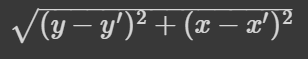

In [22]:
import math

# compares the section result to the entire result
def compare_result(section, whole):
    min_distance = 0
    for i in whole:
        temp = math.sqrt(((section[1] - i[1])**2) + ((section[0] - i[0])**2))
        if (min_distance == 0) or (min_distance > temp):
            min_distance = temp
    return min_distance

avg = 0
for point in q1_result:
    avg += compare_result(point, original_result)
avg = avg/len(q1_result)
print('Average euclidean distance', avg)

Average euclidean distance 2.4974527904553927
